# contens

1. Libarary import
2. Data Browser & preprocessing
3. 시계열분석
4. 모델링

## 1. Library improt

In [26]:
import numpy as np
import pandas as pd
import os
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import *
from sklearn.cluster import KMeans


os.chdir('C:/elec_used/data/energy')
#os.chdir('/home/lyj/elec_used/data/energy')

In [3]:
os.listdir('C:/elec_used/data/energy')
#os.listdir('/home/lyj/elec_used/data/energy')

['sample_submission.csv', 'test.csv', 'train.csv', 'train2.csv']

In [4]:
train = pd.read_csv('train.csv', encoding = 'euc-kr')
test = pd.read_csv('test.csv', encoding = 'euc-kr')
submission = pd.read_csv('sample_submission.csv', encoding='euc-kr')

In [5]:
train.head(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
5,1,2020-06-01 05,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0
6,1,2020-06-01 06,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0
7,1,2020-06-01 07,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0
8,1,2020-06-01 08,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0
9,1,2020-06-01 09,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0


In [6]:
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [7]:
submission.head(10)

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
5,1 2020-08-25 05,0
6,1 2020-08-25 06,0
7,1 2020-08-25 07,0
8,1 2020-08-25 08,0
9,1 2020-08-25 09,0


## 2. Data Browser & Preprocessing

+ 데이터 설명

```
    < train.csv >
    
        + train 데이터 : 60개 건물들의 2020년 6월 1일 부터 2020년 8월 24일까지의 데이터
        + 1시간 단위로 제공
        + 전력사용량(kWh) 포함
        + train.shape: (122400, 10)
    
    < test.csv >
    
        + test 데이터 : 60개 건물들의 2020년 8월 25일 부터 2020년 8월 31일까지의 데이터
        + 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)
        + 전력사용량(kWh) 미포함
        + test.shape: (10080, 9)
        
    
```

 + 비전기냉방설비운영(가스냉방): 0 = 없음, 1 = 있음
 + 태양광보유 : 0 = 없음, 1 = 있음

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [9]:
test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [10]:
# 건물별 '비전기 냉방설비운영' 과 '태양광보유' 를 판단해 test set의 결측치 보간
train[['num', '비전기냉방설비운영', '태양광보유']]
ice = {}
hot = {}
count = 0
for i in range(0, len(train), len(train)//60):
    count += 1
    ice[count] = train.loc[i, '비전기냉방설비운영']
    hot[count] = train.loc[i, '태양광보유']
    
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영'] = ice[test['num'][i]]
    test.loc[i, '태양광보유'] = hot[test['num'][i]]

In [11]:
# 시간, 요일, 주말여부 추가
def time(x):
    return int(x[-2:])
train['time'] = train['date_time'].apply(lambda x:time(x))
test['time'] = test['date_time'].apply(lambda x:time(x))

# 평일 = 0~4, 주말= 5~6
def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday'] = train['date_time'].apply(lambda x:weekday(x))
test['weekday'] = test['date_time'].apply(lambda x:weekday(x))

# 평일=0, 주말=1
train['weekend'] = train['weekday'].apply(lambda x: 0 if x < 4 else 1)
test['weekend'] = test['weekday'].apply(lambda x: 0 if x < 4 else 1)

In [12]:
# 기온 풍속, 습도 등, 기타 결측치 1/3, 2/3 으로 보간
test = test.interpolate(method='values')
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,weekend
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1,0
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1,0
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1,0
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1,0
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1,0
5,1,2020-08-25 05,26.500000,1.233333,81.333333,0.0,0.000000,0.0,0.0,5,1,0
6,1,2020-08-25 06,26.100000,1.300000,83.000000,0.0,0.000000,0.0,0.0,6,1,0
7,1,2020-08-25 07,27.000000,1.266667,81.000000,0.0,0.366667,0.0,0.0,7,1,0
8,1,2020-08-25 08,27.900000,1.233333,79.000000,0.0,0.733333,0.0,0.0,8,1,0
9,1,2020-08-25 09,28.800000,1.200000,77.000000,0.0,1.100000,0.0,0.0,9,1,0


In [13]:
train.head(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,weekend
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,0
5,1,2020-06-01 05,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5,0,0
6,1,2020-06-01 06,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6,0,0
7,1,2020-06-01 07,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7,0,0
8,1,2020-06-01 08,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,8,0,0
9,1,2020-06-01 09,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,9,0,0


In [14]:
# renaming colunms
train.columns = ["num", "datetime", "target", "temp", "wind", 
                 "hum", "rain", "sun", "nonelec", "solar", "time", 
                 "weekday", "weekend"]

test.columns = ["num", "datetime","temp", "wind", "hum",
                "rain", "sun", "nonelec", "solar", "time", 
                "weekday", "weekend"]

## 3. EDA

In [15]:
eda_df = train.copy()

In [16]:
# adding features related to datetime
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

### 3-1. Energy Distribution

<AxesSubplot:xlabel='target', ylabel='Count'>

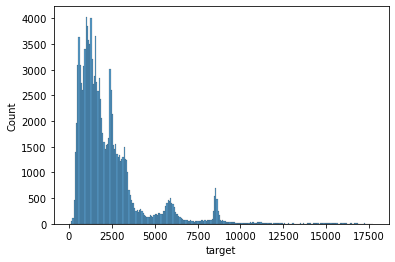

In [17]:
sns.histplot(eda_df.target)

<AxesSubplot:xlabel='target', ylabel='Count'>

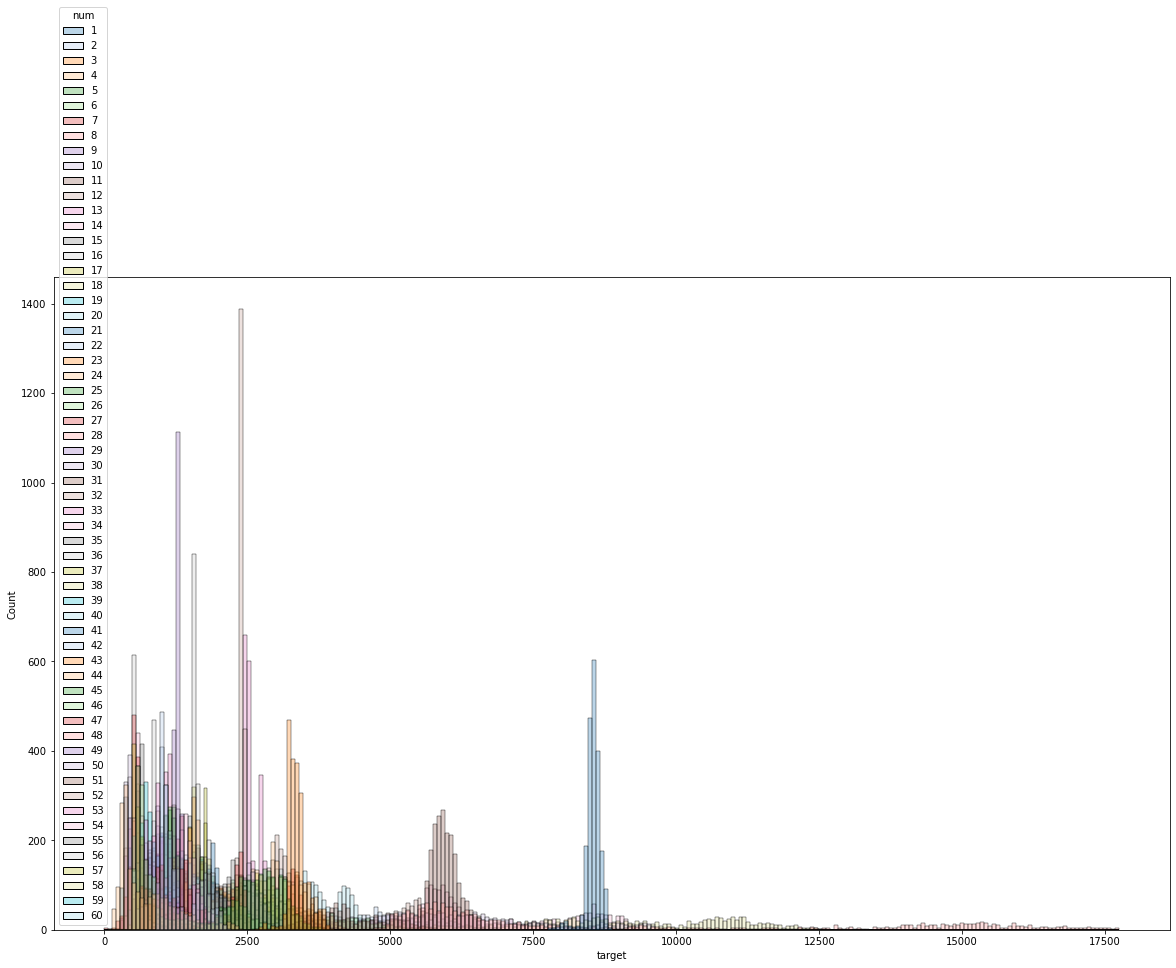

In [18]:
fig = plt.figure(figsize = (20, 12))
sns.histplot(data=eda_df, x='target', hue = 'num', alpha = 0.3, palette = 'tab20')

### 3-2. energy usage of each building in relation to datetime

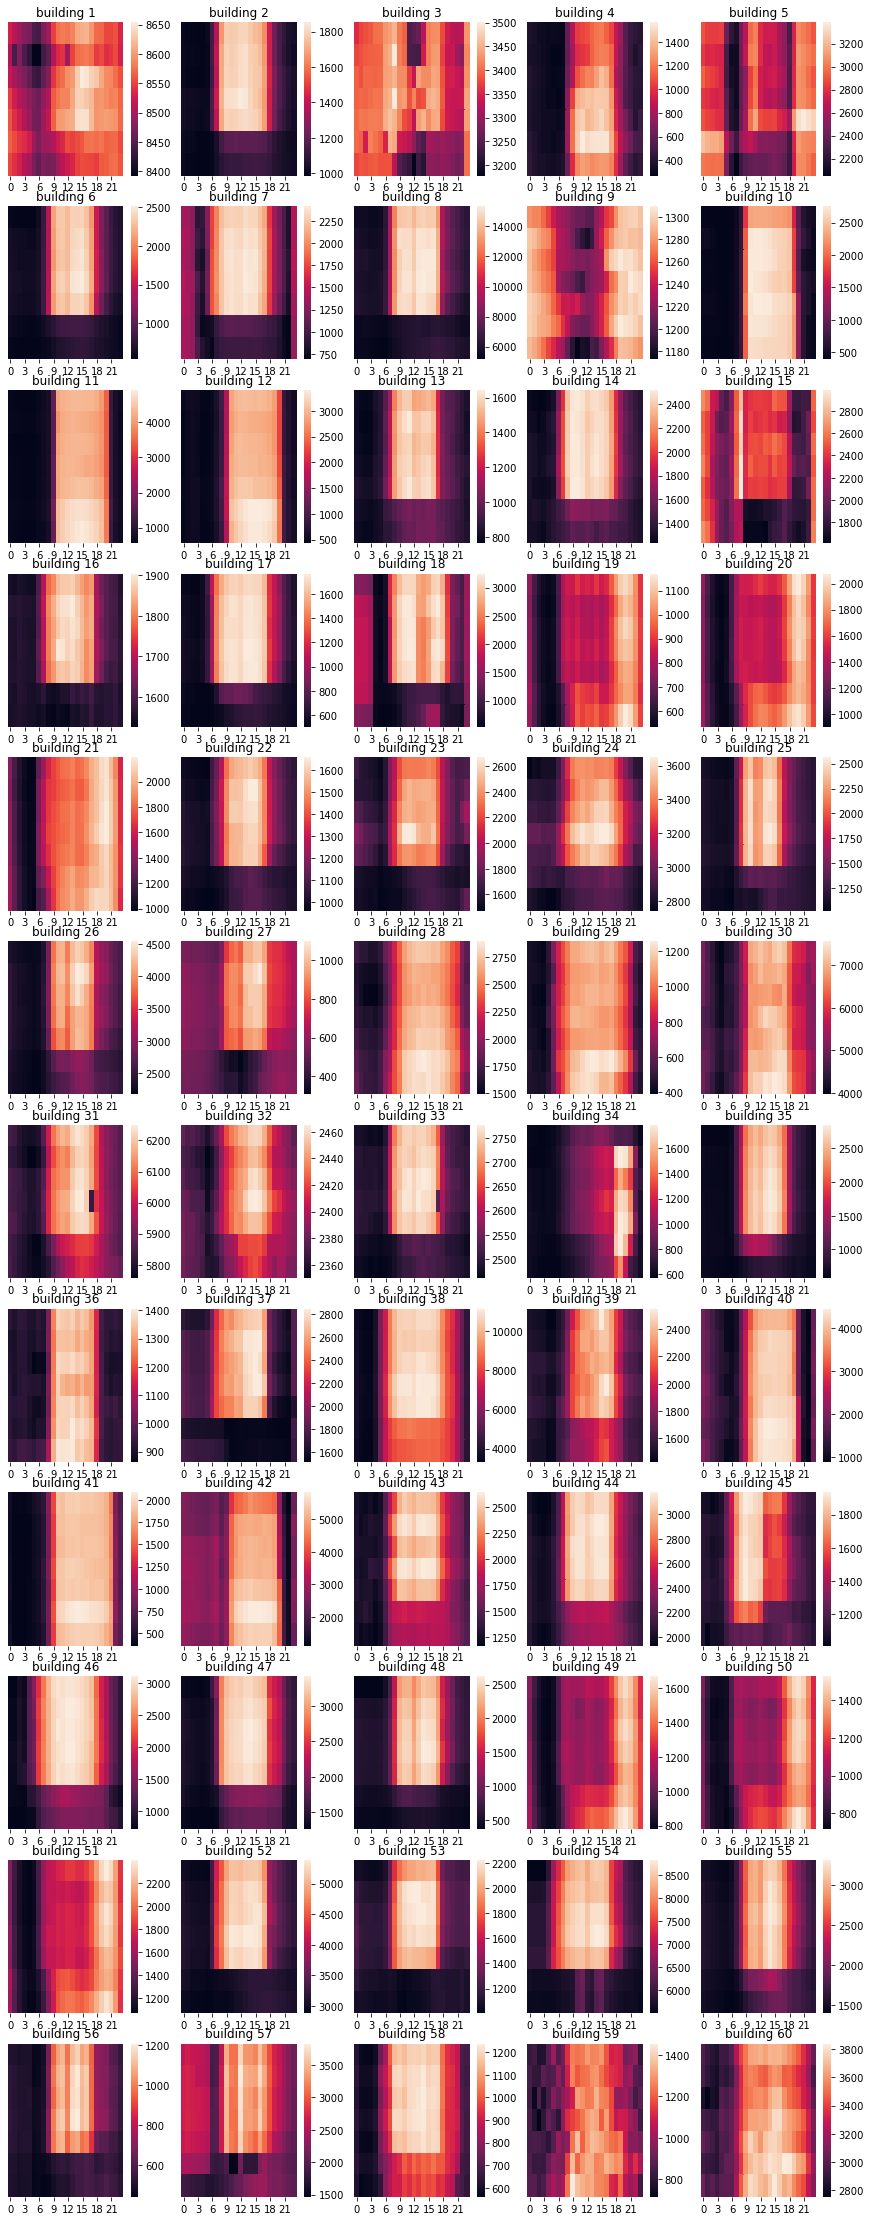

In [19]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

<AxesSubplot:xlabel='datetime', ylabel='target'>

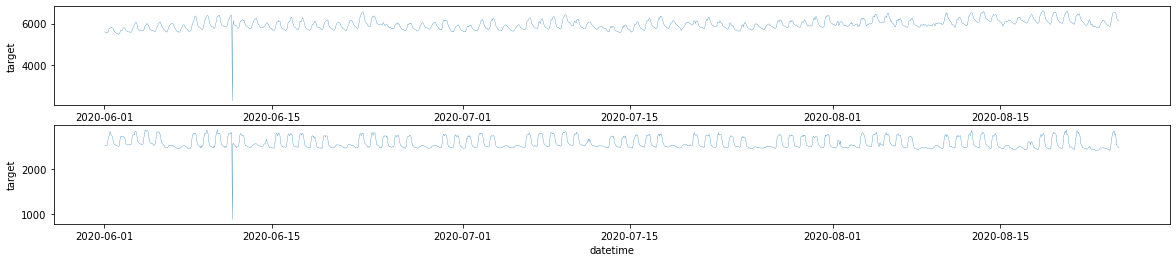

In [20]:
num_31 = eda_df[eda_df.num == 31]
num_33 = eda_df[eda_df.num == 33]

fig = plt.figure(figsize = (20, 4))
plt.subplot(211)
sns.lineplot(data = num_31, x = 'datetime', y = 'target', linewidth = 0.3)
plt.subplot(212)
sns.lineplot(data = num_33, x = 'datetime', y = 'target', linewidth = 0.3)

In [21]:
print(num_31.loc[num_31.target < 4000, 'datetime'])
print(num_33.loc[num_33.target < 2000, 'datetime'])

61457   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]
65537   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]


In [22]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [23]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

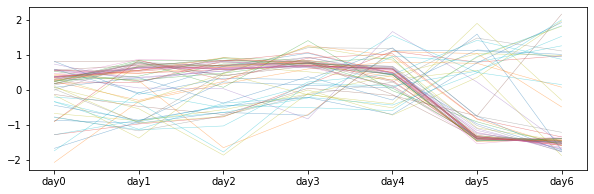

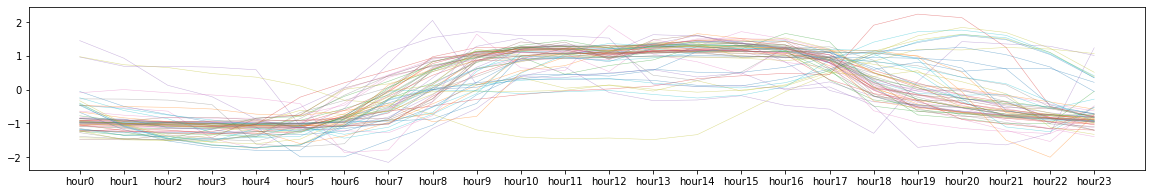

In [24]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

### K-means clusterting

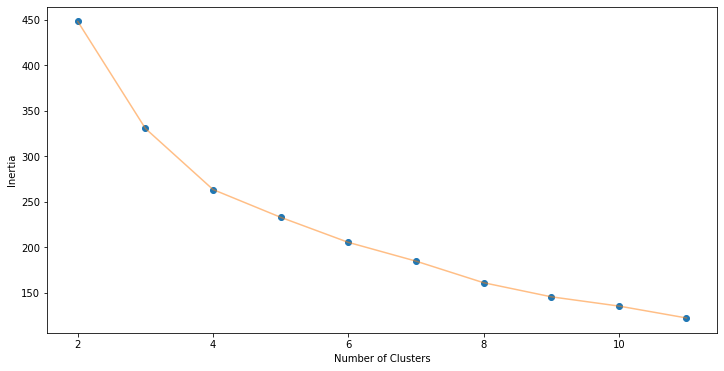

In [27]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [28]:
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

In [29]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster

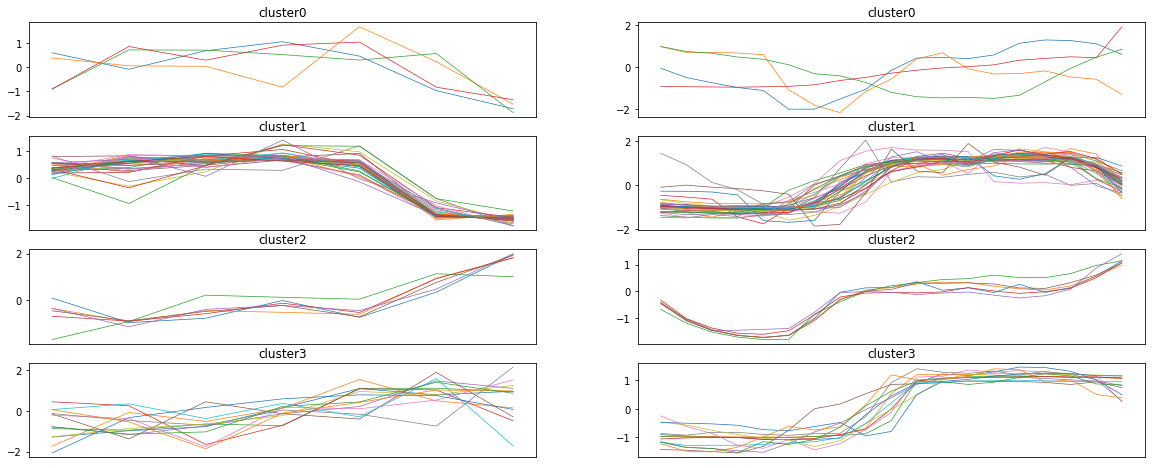

In [30]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [32]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

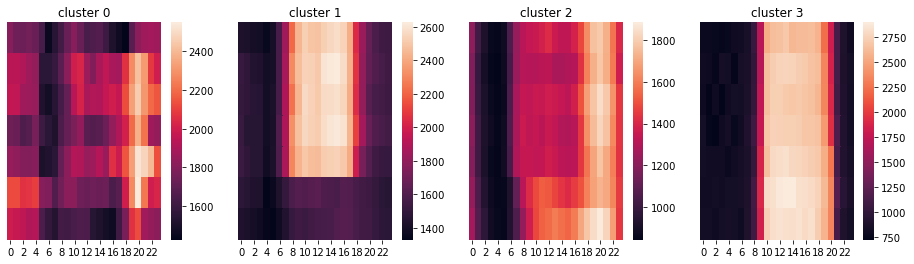

In [33]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

- cluster 0 : 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이 전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(식당, 상점, 카페)
- cluster 1 : 출근 전 시간대에 전력소모가 매우 낮고, 저녁이 될 수록 전력소모가 커짐(산업시설?)
- cluster 2 : 평일보다 주말에 전력소모가 크고, 낮보다 밤에 전력소모가 큰 건물(유흥시설, 주점)
- cluster 3 : 평일 주간에 전력소모가 크고, 평일야간이나 주말에는 전력소모가 작은 건물(사무실, 학교)

In [34]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

### Cluster Analysis

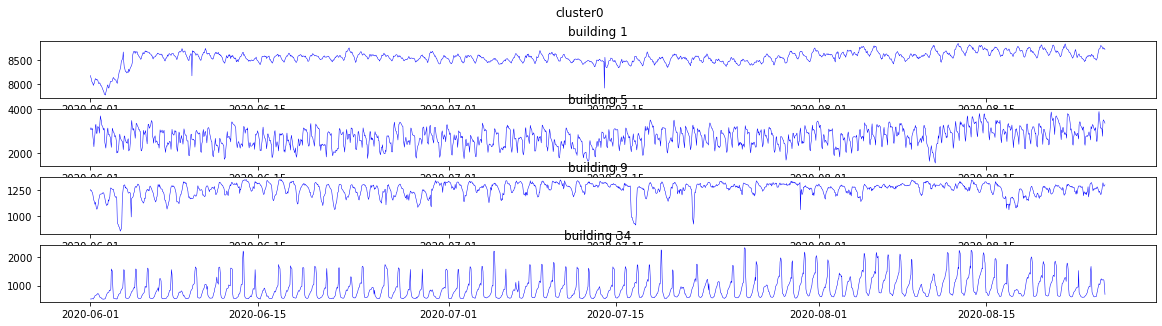

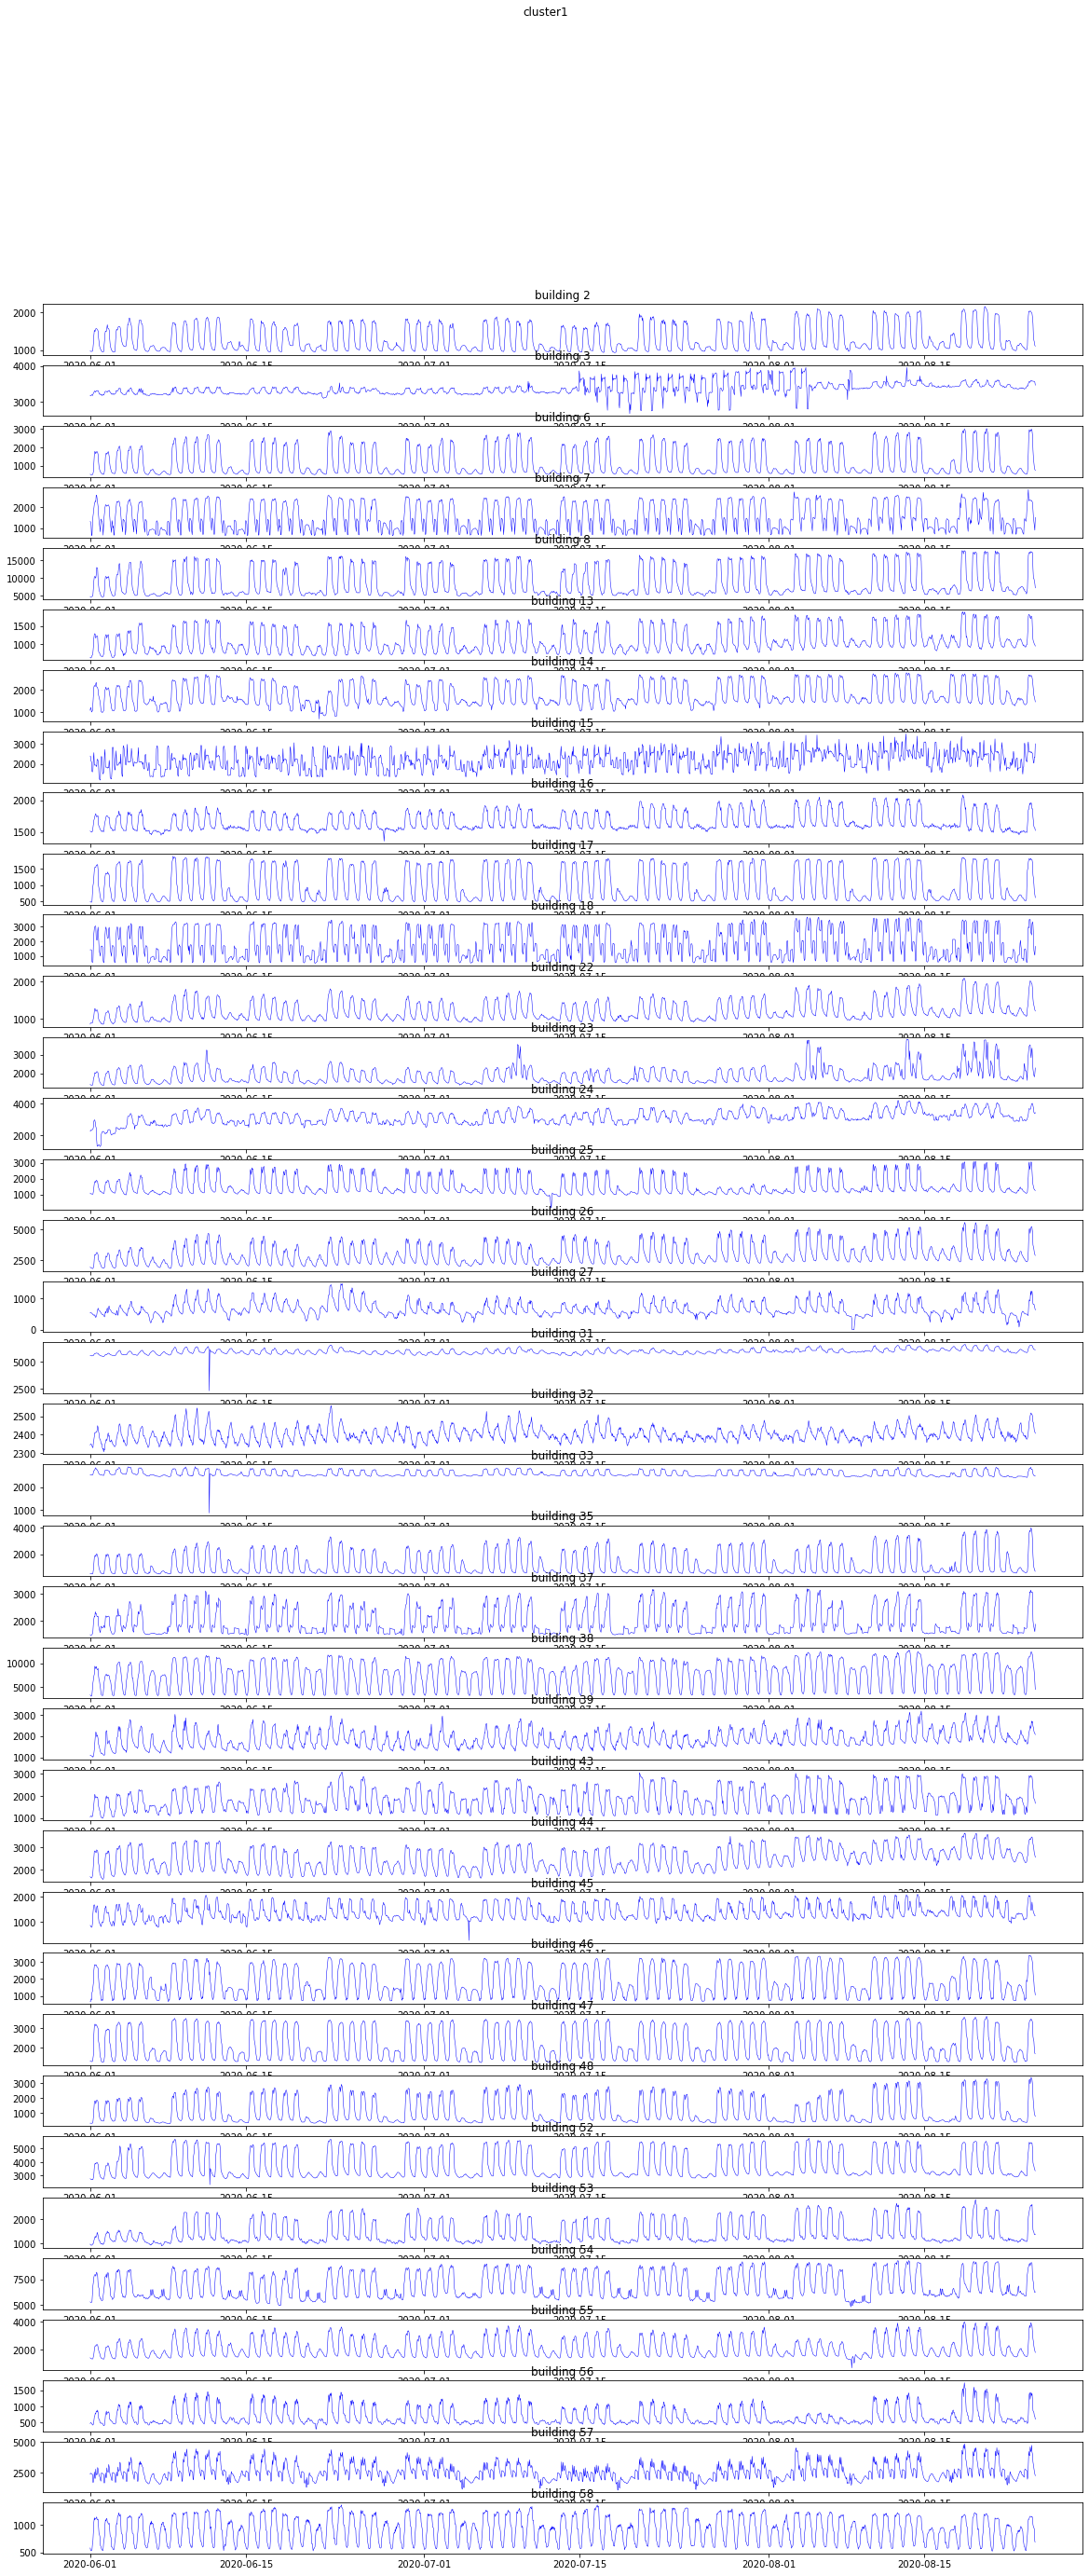

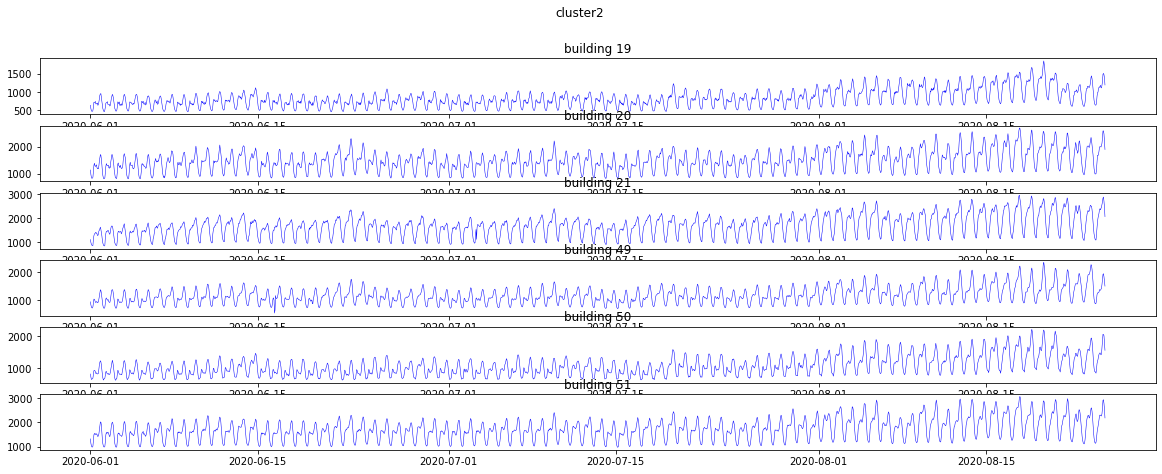

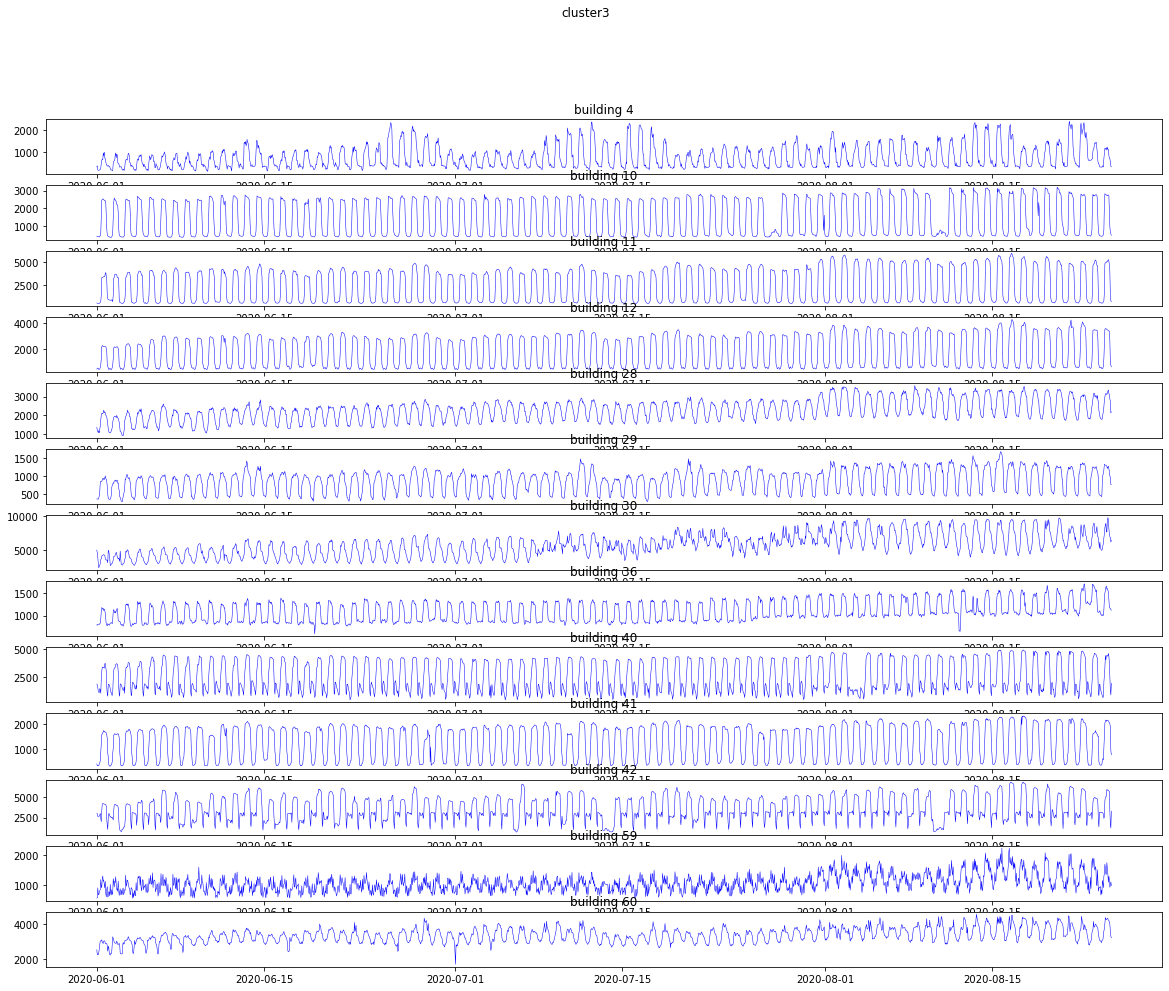

In [37]:
# linplot(energy usage of each building ~ cluster, datetime)
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 1.2*n_nums))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = 'target', linewidth = 0.5, color = 'blue')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

lineplot을 통해, 요일과 시간보다는 날짜에 초점을 맞추어 분석해보겠습니다.

- cluster 0 : 낮과 밤에 따라서 전력사용량이 증가 감소를 반복하는 경향성이 보입니다.
건물 4의 경우, 불분명한 원인으로 인해 특정 주기에 낮 전력 소요가 높아지는 현상이 보입니다.
많은 건물들에서 시간이 지남에 따라 전력소요가 증가하는 양상을 보입니다.(냉방으로 인한 것으로 보입니다.)

- cluster 1 : 한 군집으로 분류되긴 했으나, 공통적인 특징이 보이지 않습니다.
건물 1의 경우, 초반 3일동안 전력소요가 낮게 나타납니다.

- cluster 2 : 공통적으로 더위가 심해질수록 전력사용량이 점진적으로 증가합니다.
- cluster 3 : 평일과 주말이 구분되는 양상을 보입니다. 이 군집에 속한 건물들은 공통적으로 대체공휴일(8.17)에도 전력소요가 낮게 나타납니다. 

사무실과 학교 같은 일터 라는 추측에 확신을 가질 수 있습니다.
건물 3의 경우, 7.15-8.4 일동안 비정상적인 전력소요 양상이 보입니다.
건물 23의 경우, 8.4일부터 전력소요의 양상이 바뀝니다.
이 군집에 속한 대부분의 건물들에서, 점심시간(11-12시)에 전력소요가 소폭 감소하는 모습도 보입니다.


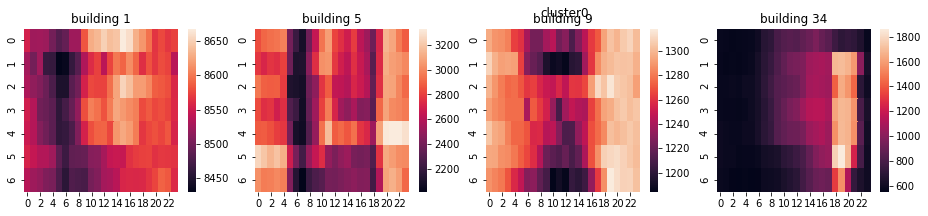

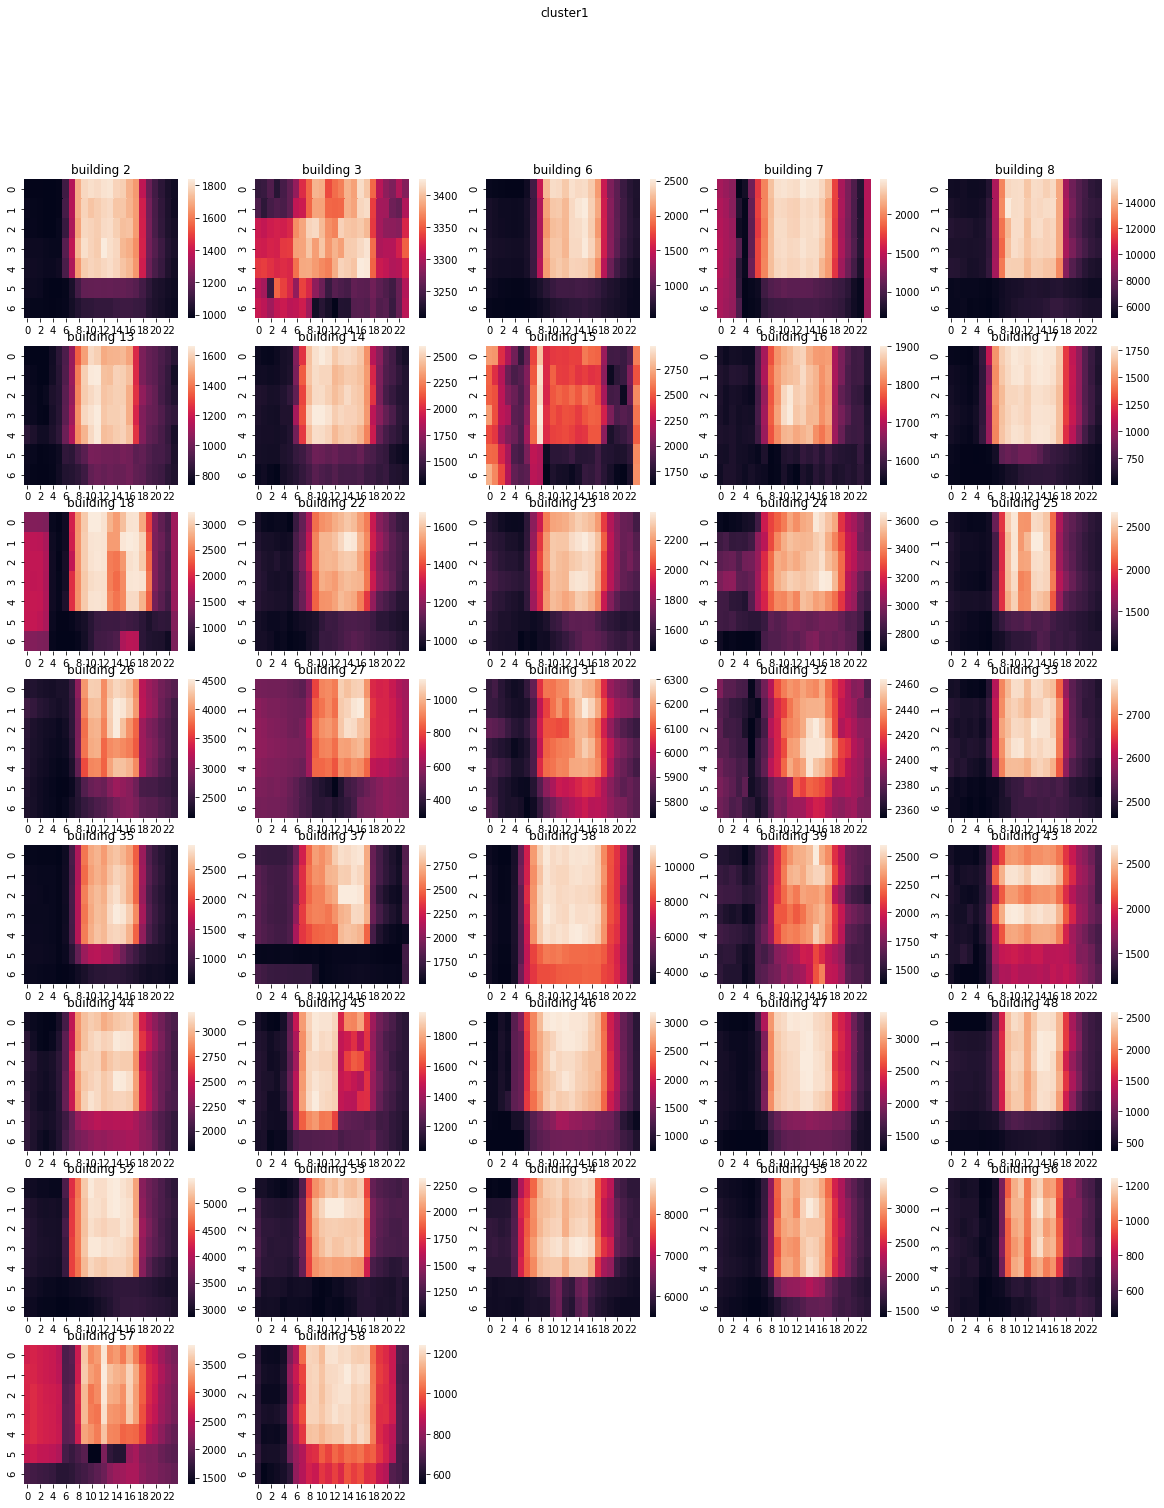

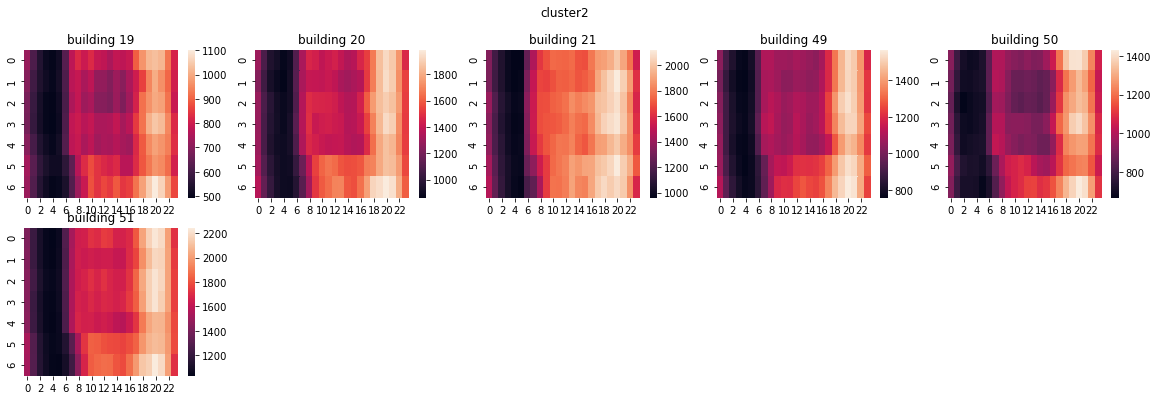

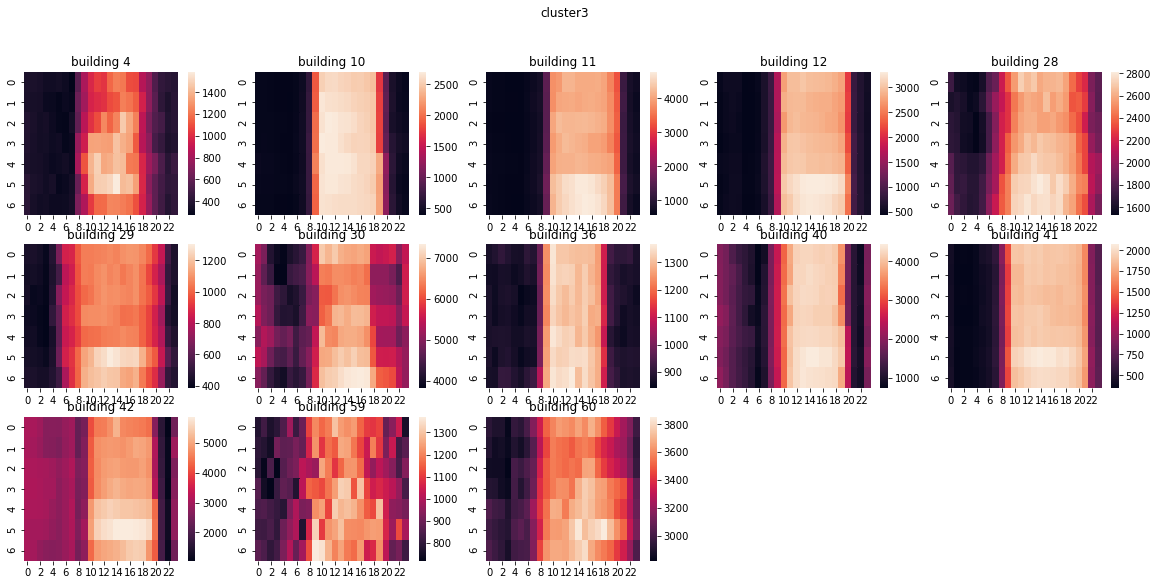

In [38]:
# heatmap(energy usage of each building ~ cluster, weekday, hour)
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 3*(n_nums//5 + 1)))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2 = temp_2.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
        plt.subplot(n_nums//5+1,5, i+1)
        sns.heatmap(temp_2)
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

## 3-3. Energy usage of each building in relation to weather

### Temperture

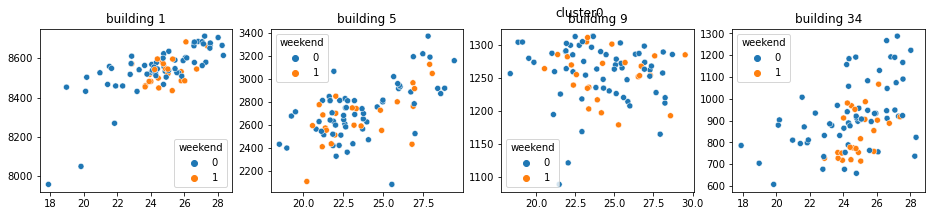

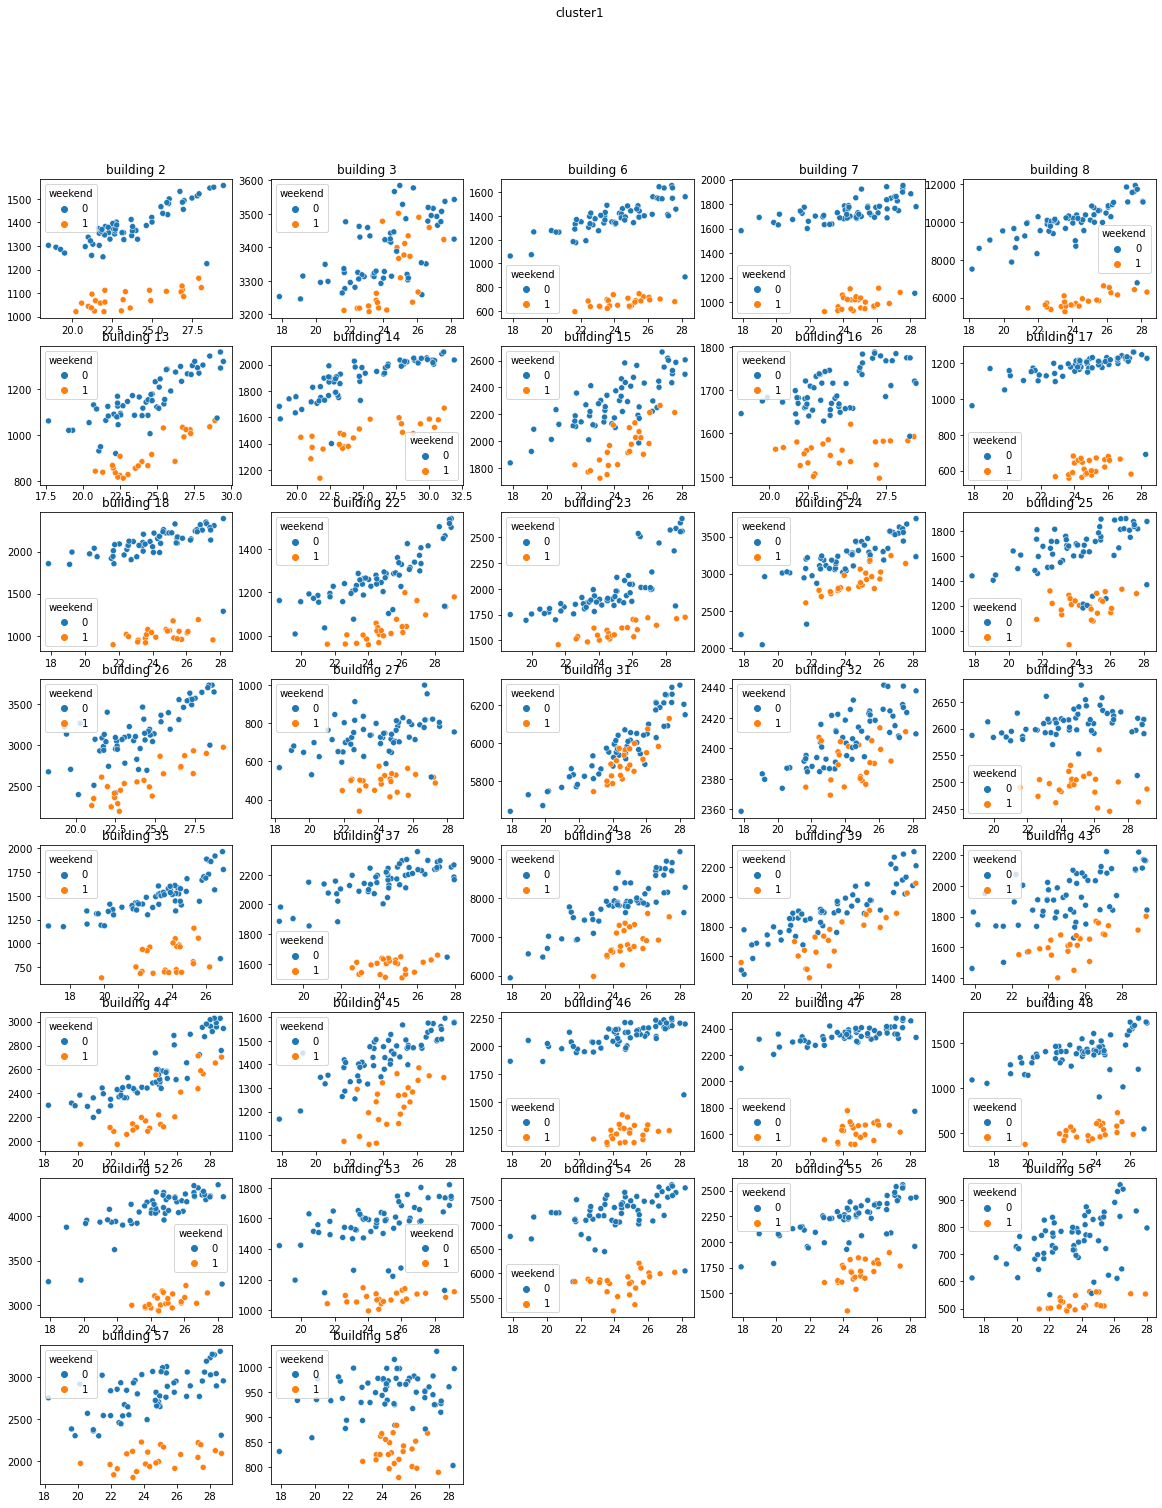

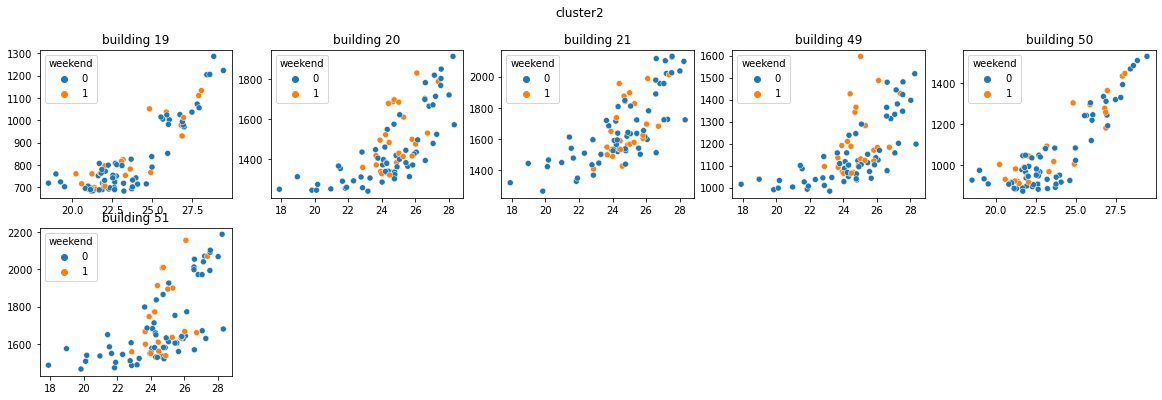

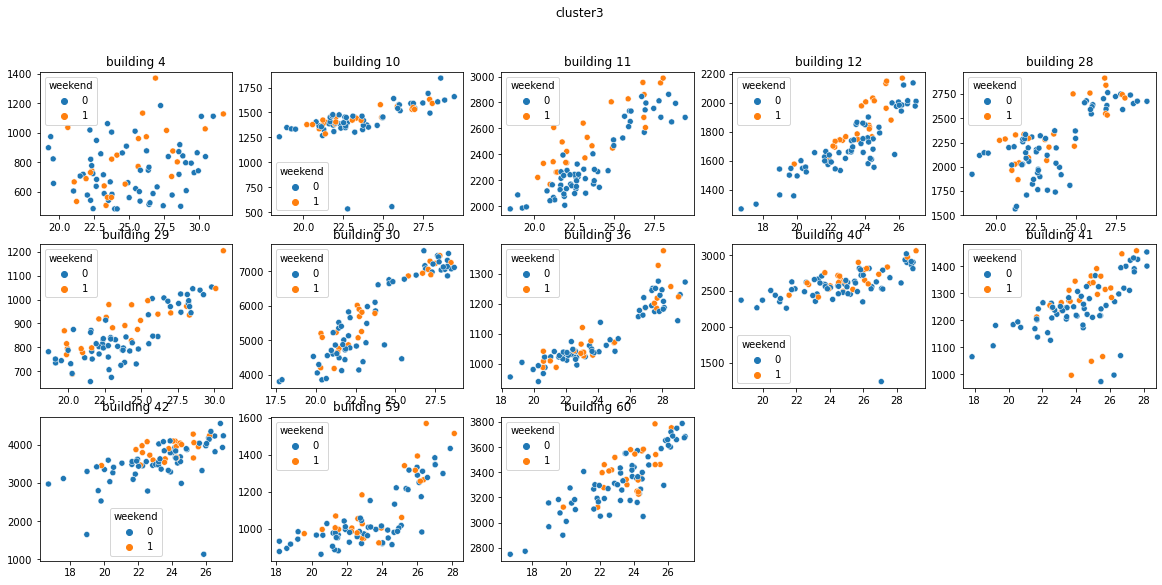

In [43]:
# 날짜별로 일평균 기온과 일평균 전력 사용량의 상관관계 파악
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 3*(n_nums//5 + 1)))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2 = temp_2.groupby(['num','date','weekend'])[['target','temp']].mean().reset_index()
        plt.subplot(n_nums//5+1,5, i+1)
        sns.scatterplot(data = temp_2, x='temp', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')